In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import nltk
%matplotlib inline

In [2]:
train=pd.read_csv("train_E6oV3lV.csv")
test=pd.read_csv("test_tweets_anuFYb8.csv")

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
comb=train.append(test,ignore_index=True)

c:\program files (x86)\python\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
#remove usernames from the text
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    return input_txt
comb['clean_tweet']=np.vectorize(remove_pattern)(comb['tweet'],"@[\w]*")

In [6]:
#remove special characters,numbers,punctuations
comb['clean_tweet']=comb['clean_tweet'].str.replace("[^a-zA-Z#]"," ")

In [7]:
#remove words with length<=3
comb['clean_tweet']=comb['clean_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

In [8]:
#tokenization
tokenized_tweet=comb['clean_tweet'].apply(lambda x: x.split())

In [9]:
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean_tweet, dtype: object

In [10]:
#stemming
from nltk.stem.porter import *
stemmer=PorterStemmer()

tokenized_tweet=tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

In [11]:
#tokenized words into sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=' '.join(tokenized_tweet[i])
comb['clean_tweet']=tokenized_tweet

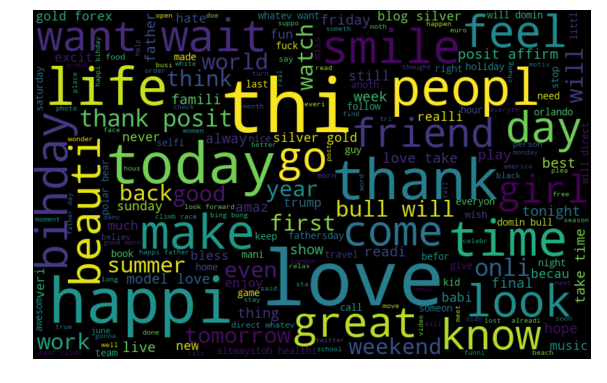

In [13]:
#visualizations
#wordcloud
all_words=' '.join([text for text in comb['clean_tweet']])
from wordcloud import WordCloud
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')

tfidf=tfidf_vectorizer.fit_transform(comb['clean_tweet'])

In [1]:
#model building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#separating train and test set
train_tfidf=tfidf[:31962,:]
test_tfidf=tfidf[31962:,:]

#splitting into train and validation sets
x_train,x_valid,y_train,y_valid=train_test_split(train_tfidf,train['label'],random_state=42,test_size=0.3)

lreg=LogisticRegression()

#training the model
lreg.fit(x_train,y_train)

pred=lreg.predict_proba(x_valid)
pred_int=pred[:,1]>=0.4
pred_int=pred_int.astype(np.int)

f1_score(y_valid,pred_int)

NameError: name 'tfidf' is not defined

In [20]:
#prediction on test set
test_pred=lreg.predict_proba(test_tfidf)
test_pred_int=test_pred[:,1]>=0.5
test_pred_int=test_pred_int.astype(np.int)

test['label']=test_pred_int

sub=test[['id','label']]
sub.to_csv("submission.csv",index=False)